In [87]:
import string
import re
import pandas as pd 
import numpy as np
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk import pos_tag
from pymorphy3 import MorphAnalyzer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
import torch
from torch import nn
from tqdm import tqdm
from catboost import CatBoostClassifier
import warnings 

warnings.filterwarnings('ignore')

## Preprocess texts

In [22]:
df = pd.read_csv('../texts_labeled.tsv', sep='\t')

In [23]:
res = df.groupby('INPUT:comment')['OUTPUT:is_infringements'].apply(lambda row: row.value_counts().idxmax()).reset_index()
res

,INPUT:comment,OUTPUT:is_infringements
0,\r\nВРЕМЯ ПИТЬ ЧАЙ!\r\nBrusnikaTea «ЯГОДНЫЙ» -...,yes
1,\r\nВкусный чай зеленый листовой ягодами земля...,no
2,\r\nИван чай Глазова Гора – традиционный русск...,no
3,\r\nИщете идеальный подарок на Новый год? Пода...,no
4,\r\nНастоящий Молочный улун высший сорт из Кит...,yes
...,...,...
2003,Яркий фруктово-ягодный купаж на основе облепих...,yes
2004,Ярко выраженное восточное благоухание зелёного...,no
2005,пакетиках 14 матча день зеленый черный рождени...,no
2006,улун дыня - разновидность крупнолистового чая...,no


In [24]:
df[df['INPUT:comment'] == '\r\nВкусный чай зеленый листовой ягодами земляники. Земляничный улун подарочный. Улун китайский и ягоды сушеные (земляника сублимированная) возвратят Вас в лето и превратят чаепитие в праздник. Сублимированные ягоды и крупнолистовой зелёный чай укрепят здоровье. Содержит витамины D, C, E, K, марганец, фосфор, железо и йод. Чай заварной с натуральными добавками выводит шлаки и токсины из организма. Напиток можно использовать для детокса и похудения. Чай с ягодами имеет обволакивающий вкус и нежный аромат. Фруктовый чай натуральный антиоксидант, полезен для похудения, укрепляет костные ткани. Чайное ассорти изготовлено без искусственных красителей и не содержит ГМО. Чай подарочный ягодный микс в подарок женщине, мужчине. Чай с фруктами можно подать во время застолья на новогодний праздник. Оригинальный и нежный вкус наверняка понравится гостям. Состав: чай китайский улун, ягоды земляники, лист брусники, натуральный земляничный ароматизатор. После него Вы забудете про чай в пакетиках. сушеные ягоды, лепестки и травы - чайный напиток с натуральными витаминами и полезными минералами. Практичный, универсальный подарок с пользой для здоровья удивит и вызовет положительные эмоции, а также даст повод собраться с друзьями и родными за чашечкой чая. После него Вы забудете про чай в пакетиках. Тонизирующее, так и успокаивающее воздействие. ']

,INPUT:comment,OUTPUT:insult,OUTPUT:nonsense,OUTPUT:profanity,OUTPUT:advertising,OUTPUT:law_violation,OUTPUT:is_infringements,GOLDEN:insult,GOLDEN:nonsense,GOLDEN:profanity,...,GOLDEN:law_violation,GOLDEN:is_infringements,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started
4853,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff1997d5f9b2330ba2f9c,5f271f4fb1d5d003e454617253cc57d8,APPROVED,2024-04-17T15:58:17.613
4901,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,True,NaN,yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff19bdaf59030df3c69c2,bfdb99f582393c82a7545545bc7044fb,APPROVED,2024-04-17T15:58:19.082
4953,\r\nВкусный чай зеленый листовой ягодами земля...,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://platform.toloka.ai/task/42935533/00028...,00028f24ed--661febdf1c7df82555cadd30,00028f24ed--661ff19cdaf59030df3c69f7,2a38e4d4e4a4736d579c9e52f33b9075,APPROVED,2024-04-17T15:58:20.522


In [25]:
names = {
    'INPUT:comment' : 'comment',
    'OUTPUT:is_infringements' : 'target'
}

In [26]:
res.rename(names, axis=1, inplace=True)

In [27]:
na = pd.DataFrame({'comment': ['Описания нет'], 'target': ['no']})


In [28]:
res = pd.concat([res, na], axis=0).reset_index().drop('index', axis=1)

In [29]:
# df['описание'] = df['описание'].fillna('Описания нет')
# df['бренд'] = df['бренд'].fillna('Бренда нет')

# df.info()

In [63]:
patterns = '[^0-9а-яА-ЯёЁ\s]+' 
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    return " ".join(tokens)

In [64]:
def preprocess_text(row):

    text = str(row).lower()
    
    # deleting punctuation
    punc = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(punc)

    # lemmatizing 
    lematized_text = lemmatize(text_no_punct)
    
    return lematized_text

In [65]:
def target_labeler(s):
    if s == 'yes':
        return 1 
    if s == 'avg':
        return 1 
    else:
        return 0 

In [66]:
preprocessed_df = res.copy()
preprocessed_df['comment'] = res['comment'].apply(preprocess_text)
preprocessed_df['target'] = preprocessed_df['target'].apply(lambda row: target_labeler(row))

## TFIDF + classical model

In [67]:
train, test = train_test_split(preprocessed_df, random_state=34, train_size=0.8)

print(train.shape)
print(test.shape)

(1607, 2)
(402, 2)


In [68]:
for sample in [train, test]:
    print(sample[sample['target']==1].shape[0] / sample.shape[0])

0.3509645301804605
0.3407960199004975


In [69]:
tfidf_1 = TfidfVectorizer(ngram_range=(1, 1))

In [70]:
tfidf_train = tfidf_1.fit_transform(train['comment'])
tfidf_test = tfidf_1.transform(test['comment'])

print(tfidf_train.shape)
print(tfidf_test.shape)

(1607, 9825)
(402, 9825)


In [71]:
lr = LogisticRegression(
    solver='lbfgs',
    random_state=33,
    max_iter=10000,
    n_jobs=-1
)

In [72]:
lr.fit(tfidf_train, train['target'])

/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


LogisticRegression(max_iter=10000, n_jobs=-1, random_state=33)

In [73]:
pred = lr.predict_proba(tfidf_test)

roc_auc_score(test['target'], pred[:,0])

/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

0.5168434099986228

/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

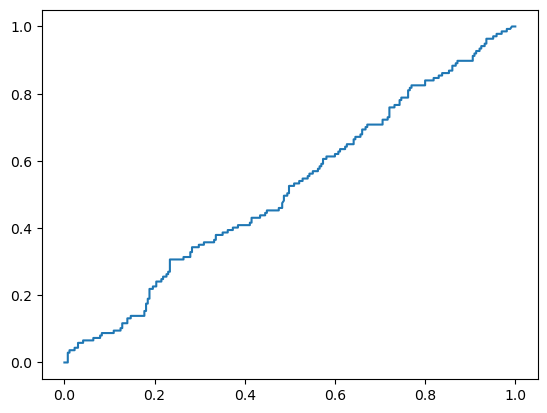

In [78]:
import matplotlib.pyplot as plt 

fpr, tpr, thres = roc_curve(test['target'], pred[:,0])

plt.plot(fpr, tpr)

In [80]:
cb = CatBoostClassifier(iterations=500, learning_rate=0.01)

cb.fit(tfidf_train, train['target'])

pred = cb.predict_proba(tfidf_test)

roc_auc_score(test['target'], pred[:,0])

0:	learn: 0.6919444	total: 39.7ms	remaining: 19.8s
1:	learn: 0.6910106	total: 63.7ms	remaining: 15.9s
2:	learn: 0.6900302	total: 83.4ms	remaining: 13.8s
3:	learn: 0.6890388	total: 103ms	remaining: 12.8s
4:	learn: 0.6880591	total: 123ms	remaining: 12.2s
5:	learn: 0.6869690	total: 144ms	remaining: 11.9s
6:	learn: 0.6860038	total: 166ms	remaining: 11.7s
7:	learn: 0.6849786	total: 185ms	remaining: 11.4s
8:	learn: 0.6841388	total: 205ms	remaining: 11.2s
9:	learn: 0.6831963	total: 225ms	remaining: 11s
10:	learn: 0.6822195	total: 245ms	remaining: 10.9s
11:	learn: 0.6813544	total: 266ms	remaining: 10.8s
12:	learn: 0.6804910	total: 287ms	remaining: 10.7s
13:	learn: 0.6796293	total: 309ms	remaining: 10.7s
14:	learn: 0.6787899	total: 335ms	remaining: 10.8s
15:	learn: 0.6779083	total: 358ms	remaining: 10.8s
16:	learn: 0.6770854	total: 379ms	remaining: 10.8s
17:	learn: 0.6762625	total: 400ms	remaining: 10.7s
18:	learn: 0.6753714	total: 420ms	remaining: 10.6s
19:	learn: 0.6745800	total: 441ms	remain

/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

0.4920258917504476

In [84]:
print(accuracy_score(train['target'], cb.predict(tfidf_train)))
print(accuracy_score(train['target'], lr.predict(tfidf_train)))

0.6944617299315494
0.7218419415059116


/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

Опробовать сетки отсюда, если нет, то гг, придется что- то думать. 
В противном случае генерация описаний или придумывание описательных фичей текста, которые могут помочь, вместо стандартных векторов

## Training embeddings

Придумать метрику оценивания док2века 

In [244]:
# creating tagged data
tagged_data = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(preprocessed_df['comment'])]

# creating model
model = Doc2Vec(vector_size=20, window=5, min_count=1, workers=4)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=10)

# receiving vecs 
vectors = pd.DataFrame(model.infer_vector(doc.words) for doc in tagged_data)


In [245]:
def target_labeler(s):
    if s == 'yes':
        return 1 
    if s == 'avg':
        return 1 
    else:
        return 0 
    
def counter(class_name):
    return preprocessed_df['target'].count()/preprocessed_df['target'][preprocessed_df['target']==class_name].count()

In [246]:
cb_df = pd.concat([vectors, preprocessed_df['target']], axis=1)
cb_df['target'] = cb_df['target'].apply(lambda row: target_labeler(row))
weights = [counter(0), counter(1), counter(2)]
cb_df


/var/folders/pd/fjb9sj5x6t3dnxtpzxxzkv6c0000gn/T/ipykernel_80381/2842022800.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return preprocessed_df['target'].count()/preprocessed_df['target'][preprocessed_df['target']==class_name].count()


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,-0.304238,0.058548,-0.393828,0.192414,0.035616,0.153844,-1.228948,1.170260,-1.098753,0.622526,...,0.272975,0.711092,0.078130,0.276296,1.636008,0.248287,0.094031,-0.600057,-0.840404,1
1,-0.471796,-0.087564,0.010217,0.334367,-0.210308,0.099958,0.465896,0.350809,0.199860,0.027988,...,-0.124313,0.742142,-0.876377,-0.677236,0.264769,0.043377,0.502959,-0.161147,-0.770310,0
2,0.210933,0.423158,-0.487552,-0.099956,-0.519385,0.126770,-0.394767,0.417637,-0.370297,0.551856,...,-0.028956,0.017955,0.035069,0.565732,0.432409,0.147170,-0.264441,0.008269,-0.872901,0
3,-0.688178,0.990428,-0.166007,0.244993,-1.060197,-0.377757,0.541556,0.112058,0.470977,1.907684,...,0.287184,0.797605,-1.859305,0.331733,0.053587,-1.333803,0.575027,0.364586,-0.773589,0
4,-0.191507,0.272527,0.088718,0.861700,-0.002423,-0.074680,0.090964,0.504523,-1.163597,-0.287882,...,0.033439,0.500932,-0.247236,0.374541,0.375338,1.243106,0.041166,0.149474,-0.546826,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,-0.156482,0.457846,-0.096822,0.349303,-0.134549,-0.009986,-0.189469,0.311684,-0.144037,-0.207856,...,0.051942,0.240533,-0.198981,0.251226,0.381439,0.344276,-0.254792,-0.114064,-0.344442,0
2005,0.243003,-0.382624,-0.727115,0.698112,-1.059367,-0.272852,1.039443,-0.140098,1.494975,1.409089,...,0.288886,-0.101219,-0.563027,-0.402106,-0.549187,-1.048501,0.708347,0.785643,0.118356,0
2006,-0.103773,0.556599,-0.105517,1.083823,-0.310087,-0.252894,-0.308863,0.540696,-0.655518,0.324976,...,-0.053354,0.381234,-0.186382,0.934864,0.586115,1.020601,-0.292361,-0.390039,-0.897313,0
2007,-0.084710,0.041328,-0.147151,0.030937,0.059413,-0.025368,-0.124142,0.318329,-0.261076,0.218573,...,0.180525,0.050458,-0.122238,0.092913,0.156755,0.033242,0.077432,-0.120174,-0.316188,0


In [247]:
cb_df.target.value_counts()

target
0    1308
1     701
Name: count, dtype: int64

In [248]:
X = cb_df.drop('target', axis=1)
y = cb_df.target 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, train_size=0.8)

In [249]:
np.unique(y_train)

array([0, 1])

In [250]:
cb = CatBoostClassifier(iterations=1000, learning_rate=0.01, scale_pos_weight=cb_df['target'][cb_df['target']==1].count()/cb_df['target'][cb_df['target']==0].count())


cb.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6892513	test: 0.6895080	best: 0.6895080 (0)	total: 10.4ms	remaining: 10.4s
1:	learn: 0.6854618	test: 0.6859407	best: 0.6859407 (1)	total: 14.8ms	remaining: 7.36s
2:	learn: 0.6818948	test: 0.6825335	best: 0.6825335 (2)	total: 19.2ms	remaining: 6.38s
3:	learn: 0.6783948	test: 0.6791560	best: 0.6791560 (3)	total: 33.7ms	remaining: 8.4s
4:	learn: 0.6748993	test: 0.6757733	best: 0.6757733 (4)	total: 50.9ms	remaining: 10.1s
5:	learn: 0.6713754	test: 0.6726122	best: 0.6726122 (5)	total: 59ms	remaining: 9.78s
6:	learn: 0.6678460	test: 0.6693325	best: 0.6693325 (6)	total: 62ms	remaining: 8.79s
7:	learn: 0.6645780	test: 0.6661551	best: 0.6661551 (7)	total: 66.9ms	remaining: 8.3s
8:	learn: 0.6612527	test: 0.6632164	best: 0.6632164 (8)	total: 70.9ms	remaining: 7.8s
9:	learn: 0.6580657	test: 0.6601773	best: 0.6601773 (9)	total: 72.4ms	remaining: 7.17s
10:	learn: 0.6549762	test: 0.6574237	best: 0.6574237 (10)	total: 73.9ms	remaining: 6.65s
11:	learn: 0.6519923	test: 0.6544902	best: 0.654

In [251]:
preprocessed_df['target'].value_counts()

target
no     1308
yes     504
avg     197
Name: count, dtype: int64

In [252]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [253]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

pred = cb.predict(X_test)
print(accuracy_score(y_test, pred))
print(recall_score(y_test, pred))
print(precision_score(y_test, pred))


0.6343283582089553
0.0
0.0


/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/nikitasenyatkin/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

## Test bert for embeddings

In [254]:
res['target'] = res['target'].apply(lambda x: target_labeler(x))
res['target'].value_counts()

target
0    1308
1     701
Name: count, dtype: int64

In [264]:
comments = res['comment'].to_list()
labels = res['target'].to_list()

In [277]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# Токенизация данных
input_ids = []
attention_masks = []

for comment in comments:
    encoded_data = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=64,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [266]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [267]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

In [268]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

In [271]:
res['target'].value_counts()
weights = torch.tensor([3.2, 0.6]).float()

weights

tensor([3.2000, 0.6000])

In [272]:
# criterion = nn.CrossEntropyLoss(weight=weights)

In [273]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [278]:
train_loss_set = []
train_accuracy_set = []
validation_accuracy_set = []

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

model.train()
for epoch in range(8):
    total_train_accuracy = 0
    total_train_loss = 0
    # Проход по батчам тренировочных данных
    for step, batch in enumerate(tqdm(train_dataloader, desc="Epoch {}".format(epoch))):
        batch = tuple(t.to('cpu') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        model.zero_grad()
        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs.logits
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        # Переместите logits и labels в CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_train_accuracy += flat_accuracy(logits, label_ids)
    
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy_set.append(avg_train_accuracy)
    train_loss_set.append(avg_train_loss)
    
    print(" Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    print(" Average training loss: {0:.2f}".format(avg_train_loss))


    model.eval()
    total_eval_accuracy = 0

    for batch in validation_dataloader:
        batch = tuple(t.to('cpu') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    validation_accuracy_set.append(avg_val_accuracy)
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))



Epoch 0: 100%|██████████| 57/57 [03:20<00:00,  3.52s/it]


 Average training accuracy: 0.65
 Average training loss: 0.65
 Validation Accuracy: 0.63


Epoch 1: 100%|██████████| 57/57 [02:48<00:00,  2.96s/it]


 Average training accuracy: 0.66
 Average training loss: 0.63
 Validation Accuracy: 0.63


Epoch 2: 100%|██████████| 57/57 [02:52<00:00,  3.03s/it]


 Average training accuracy: 0.70
 Average training loss: 0.56
 Validation Accuracy: 0.58


Epoch 3: 100%|██████████| 57/57 [02:53<00:00,  3.04s/it]


 Average training accuracy: 0.83
 Average training loss: 0.38
 Validation Accuracy: 0.53


Epoch 4: 100%|██████████| 57/57 [02:53<00:00,  3.04s/it]


 Average training accuracy: 0.89
 Average training loss: 0.26
 Validation Accuracy: 0.45


Epoch 5: 100%|██████████| 57/57 [02:53<00:00,  3.04s/it]


 Average training accuracy: 0.93
 Average training loss: 0.20
 Validation Accuracy: 0.53


Epoch 6: 100%|██████████| 57/57 [02:55<00:00,  3.08s/it]


 Average training accuracy: 0.95
 Average training loss: 0.14
 Validation Accuracy: 0.53


Epoch 7: 100%|██████████| 57/57 [02:58<00:00,  3.13s/it]


 Average training accuracy: 0.95
 Average training loss: 0.12
 Validation Accuracy: 0.52


In [90]:
print(torch.cuda.is_available())


False


## Начинаем с простых методов